### General settings

In [1]:
import numpy as np
# import scipy.io
# import ntplib
import datetime
# from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import os
import pandas as pd
from moviepy.editor import VideoFileClip, concatenate_videoclips
import scipy.io

In [2]:
subject = 1
walk = 6
fps_gopro = None

In [3]:
def extract_video_subset(video_path, start_frame, end_frame, output_path, fps=None):
    """
    Extract a subset of frames from a video file while keeping a subset of the audio.

    Parameters:
        video_path (str): Path to the input video file.
        start_frame (int): Starting frame index.
        end_frame (int): Ending frame index.
        output_path (str): Path to save the output video file.
        fps (int): Frame frequency of video clip (frame per second). Use video_clip.fps if not set.
    """
    # Load video clip
    video_clip = VideoFileClip(video_path)
    if fps is None:
        fps = video_clip.fps

    # print("video_clip.fps:", video_clip.fps)

    # Extract audio
    audio_clip = video_clip.audio

    # Extract subset of audio
    subset_audio_clip = audio_clip.subclip(start_frame / fps, end_frame / fps)

    # Extract subset of frames
    subset_clip = video_clip.subclip(start_frame / fps, end_frame / fps)

    # Set audio for subset clip
    subset_clip = subset_clip.set_audio(subset_audio_clip)

    # Write video file with audio
    subset_clip.write_videofile(output_path, codec="libx264", audio_codec="aac", logger=None)

    # Close the video clip
    video_clip.close()


def extract_video_noaudio_subset(video_path, start_frame, end_frame, output_path, fps=None):
    """
    Extract a subset of frames from a video file without including audio.

    Parameters:
        video_path (str): Path to the input video file.
        start_frame (int): Starting frame index.
        end_frame (int): Ending frame index.
        output_path (str): Path to save the output video file.
        fps (int): Frame frequency of video clip (frame per second). Use video_clip.fps if not set.
    """
    # Load video clip
    video_clip = VideoFileClip(video_path)
    if fps is None:
        fps = video_clip.fps

    # Extract subset of frames
    subset_clip = video_clip.subclip(start_frame / fps, end_frame / fps)

    # Write video file without audio
    subset_clip.write_videofile(output_path, codec="libx264", audio=False, logger=None)

    # Close the video clip
    video_clip.close()

def extract_video_audio_subset(video_path, start_frame, end_frame, output_video_path, output_audio_path, fps=None):
    """
    Extract a subset of frames from a video file and save the video and audio separately.

    Parameters:
        video_path (str): Path to the input video file.
        start_frame (int): Starting frame index.
        end_frame (int): Ending frame index.
        output_video_path (str): Path to save the output video file.
        output_audio_path (str): Path to save the output audio file.
        fps (int): Frame frequency of video clip (frame per second). Use video_clip.fps if not set.
    """
    # Validate input parameters
    if not os.path.isfile(video_path):
        raise FileNotFoundError(f"Video file not found at {video_path}")
    if start_frame < 0 or end_frame < 0:
        raise ValueError("Frame indices must be non-negative")
        # return "Frame indices must be non-negative"
    if end_frame <= start_frame:
        raise ValueError("End frame must be greater than start frame")
        # return "End frame must be greater than start frame"

    # Load video clip
    video_clip = VideoFileClip(video_path)
    if fps is None:
        fps = video_clip.fps

    # Extract subset of frames
    subset_clip = video_clip.subclip(start_frame / fps, end_frame / fps)

    # Write video file
    subset_clip.write_videofile(output_video_path, codec="libx264", logger=None)

    # Close the video clip
    subset_clip.close()

    # Extract audio
    audio_clip = video_clip.audio

    # Calculate time in seconds for subclipping
    start_time = start_frame / fps
    end_time = end_frame / fps

    # Extract subset of audio
    subset_audio_clip = audio_clip.subclip(start_time, end_time)

    # Write audio file
    subset_audio_clip.write_audiofile(output_audio_path, logger=None)

    # Close the audio clip
    subset_audio_clip.close()

    # Close the video clip
    video_clip.close()


def matlab_datenum_to_formatted_string(matlab_datenum):

    # Convert MATLAB datenum to Python datenum by subtracting the MATLAB epoch
    python_datenum = matlab_datenum

    # Convert Python datenum to datetime
    python_datetime = datetime.datetime.fromordinal(int(python_datenum)) + datetime.timedelta(days=python_datenum % 1) - datetime.timedelta(days=366)

    # Format datetime string
    formatted_string = python_datetime.strftime("%Y-%m-%d_%H-%M-%S-%f")[:-3]

    return formatted_string


def calculate_duration(datetime_str1, datetime_str2):
    """
    Calculate the duration between two datetime strings.

    Parameters:
        datetime_str1 (str): First datetime string.
        datetime_str2 (str): Second datetime string.

    Returns:
        datetime.timedelta: Duration between the two datetime strings.
    """
    # Convert the datetime strings to datetime objects
    datetime_obj1 = datetime.datetime.strptime(datetime_str1, '%Y-%m-%d_%H-%M-%S-%f')
    datetime_obj2 = datetime.datetime.strptime(datetime_str2, '%Y-%m-%d_%H-%M-%S-%f')

    # Calculate the duration
    duration = datetime_obj2 - datetime_obj1

    # Return the duration
    return duration


def find_close_frame(time_label, time_data_array):

    frame_index_data = 0
    time_label_num = datetime.datetime.strptime(time_label, '%Y-%m-%d_%H-%M-%S-%f')

    for temp_index in range(time_data_array.shape[0]):

        temp_time_data = datetime.datetime.strptime(time_data_array[temp_index], '%Y-%m-%d_%H-%M-%S-%f')

        if temp_time_data >= time_label_num:

            frame_index_data = temp_index
            # print("syncronze frame: ", frame_index_data, time_label, time_data_array[temp_index])
            break

    return frame_index_data


In [4]:
# fre_np = 250, fre_gopro = 60, fre_pupil = 60
# Load all data and timestamp: Neural-Pace (NP) signal, GoPro videos, Pupil videos, Xsens, phone (acc, gyro, mag, GPS, light, audio)
load_syncronized_folder = f'../../RW{subject}/RW{subject}-Walk{walk}-extracted/'
save_syncronized_splt_folder = f'../../synchronized/RW{subject}/RW{subject}-Walk{walk}-self-syncronize-split/'

if not os.path.exists(save_syncronized_splt_folder):
    # Create the directory
    os.makedirs(save_syncronized_splt_folder)

In [13]:
# Event Description PupilFrame  GoProFrame  NPSample    NTP
df = pd.read_csv(f'../../label_RWNApp_Output_Jan2024/evnts_RWNApp_RW{subject}_Walk{walk}.csv')
label = df['Event']
ntp_label = df['NTP']
# PupilFrame = df['PupilFrame']
GoProFrame = df['GoProFrame']
NPSample = df['NPSample']

# convert matlab NTP time to datetime timestamp
time_label = [matlab_datenum_to_formatted_string(md) for md in ntp_label/60/60/24]
# np.save(save_folder + "time_label", time_label)
num_of_label = len(time_label)


# Neural-Pace (NP) signal, GoPro videos, Pupil videos, Xsens, phone (acc, gyro, mag, GPS, light, audio)
# fre_np = 250, fre_gopro = 60, fre_pupil = 60


## load np data
data_np = np.load(load_syncronized_folder + 'data_np.npy')
time_np = np.load(load_syncronized_folder + 'time_np.npy')

## load Gopro video
data_gopro = load_syncronized_folder + 'data_video_gopro.mp4'
time_gopro = np.load(load_syncronized_folder + 'time_gopro.npy')

## load Pupil video
data_pupil = load_syncronized_folder + 'data_video_pupil.mp4'
time_pupil = np.load(load_syncronized_folder + 'time_pupil.npy')

## load xsense data: only center of mass currently
df_xsense = pd.read_csv(load_syncronized_folder + 'data_xs_Center-of-Mass.csv')
time_xsense = np.load(load_syncronized_folder + 'time_xs.npy')
# frame_xsense = df_xsense['Frame']
data_xsense = df_xsense.iloc[:, 1:]

## load all of chestphone data
df = pd.read_csv(load_syncronized_folder + "data_chest_phone_acc.csv", header=None)
time_chestphone_acc = df.iloc[:, 0]
data_chestphone_acc = df.iloc[:, 1:]
print("chest acc:", time_chestphone_acc.shape, time_chestphone_acc.iloc[0], data_chestphone_acc.shape, data_chestphone_acc.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_gyro.csv", header=None)
time_chestphone_gyro = df.iloc[:, 0]
data_chestphone_gyro = df.iloc[:, 1:]
print("chest gyro:", time_chestphone_gyro.shape, time_chestphone_gyro.iloc[0], data_chestphone_gyro.shape, data_chestphone_gyro.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_mag.csv", header=None)
time_chestphone_mag = df.iloc[:, 0]
data_chestphone_mag = df.iloc[:, 1:]
print("chest mag:", time_chestphone_mag.shape, time_chestphone_mag.iloc[0], data_chestphone_mag.shape, data_chestphone_mag.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_light.csv", header=None)
time_chestphone_light = df.iloc[:, 0]
data_chestphone_light = df.iloc[:, 1:]
print("chest light:", time_chestphone_light.shape, time_chestphone_light.iloc[0], data_chestphone_light.shape, data_chestphone_light.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_gps.csv", header=None)
time_chestphone_gps = df.iloc[:, 0]
data_chestphone_gps_1 = df.iloc[:, 1].str.extract(r'Lat: (\d+\.\d+)', expand=False)## delete the str of "Lat:"
data_chestphone_gps_1 = np.array(data_chestphone_gps_1.astype(float))
data_chestphone_gps_2 = df.iloc[:, 2].str.extract(r'Long: (-?\d+\.\d+)', expand=False)## delete the str of "Long:"
data_chestphone_gps_2 = np.array(data_chestphone_gps_2.astype(float))
data_chestphone_gps = np.stack((data_chestphone_gps_1, data_chestphone_gps_2), axis=1)
print("chest gps:", time_chestphone_gps.shape, time_chestphone_gps[0], data_chestphone_gps.shape, data_chestphone_gps[0])


## load all of pupilphone data
df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_acc.csv", header=None)
time_pupilphone_acc = df.iloc[:, 0]
data_pupilphone_acc = df.iloc[:, 1:]
print("pupil acc:", time_pupilphone_acc.shape, time_pupilphone_acc.iloc[0], data_pupilphone_acc.shape, data_pupilphone_acc.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_gyro.csv", header=None)
time_pupilphone_gyro = df.iloc[:, 0]
data_pupilphone_gyro = df.iloc[:, 1:]
print("pupil gyro:", time_pupilphone_gyro.shape, time_pupilphone_gyro.iloc[0], data_pupilphone_gyro.shape, data_pupilphone_gyro.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_mag.csv", header=None)
time_pupilphone_mag = df.iloc[:, 0]
data_pupilphone_mag = df.iloc[:, 1:]
print("pupil mag:", time_pupilphone_mag.shape, time_pupilphone_mag.iloc[0], data_pupilphone_mag.shape, time_pupilphone_mag.iloc[0])

df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_gps.csv", header=None)
time_pupilphone_gps = df.iloc[:, 0]
data_pupilphone_gps_1 = df.iloc[:, 1].str.extract(r'Lat: (\d+\.\d+)', expand=False)## delete the str of "Lat:"
data_pupilphone_gps_1 = np.array(data_pupilphone_gps_1.astype(float))
data_pupilphone_gps_2 = df.iloc[:, 2].str.extract(r'Long: (-?\d+\.\d+)', expand=False)## delete the str of "Long:"
data_pupilphone_gps_2 = np.array(data_pupilphone_gps_2.astype(float))
data_pupilphone_gps = np.stack((data_pupilphone_gps_1, data_pupilphone_gps_2), axis=1)
print("pupil gps:", time_pupilphone_gps.shape, time_pupilphone_gps[0], data_pupilphone_gps.shape, data_pupilphone_gps[0])

print("xs:", time_xsense.shape, data_xsense.shape, time_xsense[0], time_xsense[-1])

chest acc: (98148,) 2021-04-28_13-18-09-798 (98148, 3) 1   -0.051651
2   -0.392578
3    9.850769
Name: 0, dtype: float64
chest gyro: (49309,) 2021-04-28_13-18-09-804 (49309, 3) 1    0.003494
2    0.000366
3   -0.000443
Name: 0, dtype: float64
chest mag: (47866,) 2021-04-28_13-18-09-807 (47866, 3) 1     3.361511
2    17.485046
3   -15.209961
Name: 0, dtype: float64
chest light: (3573,) 2021-04-28_13-18-09-793 (3573, 1) 1    115.0
Name: 0, dtype: float64
chest gps: (139,) 2021-04-28_13-18-16-612 (139, 2) [  34.065751  -118.4444017]
pupil acc: (80805,) 2021-04-28_13-18-09-682 (80805, 3) 1   -0.139983
2   -0.917468
3    9.708962
Name: 0, dtype: float64
pupil gyro: (47160,) 2021-04-28_13-18-09-687 (47160, 3) 1    0.004977
2   -0.008549
3   -0.004021
Name: 0, dtype: float64
pupil mag: (47947,) 2021-04-28_13-18-09-684 (47947, 3) 2021-04-28_13-18-09-684
pupil gps: (152,) 2021-04-28_13-18-16-334 (152, 2) [  34.0658759 -118.4444309]
xs: (112216,) (112216, 9) 2021-04-28_13-20-49-664 2021-04-28_13

In [ ]:
## Merge gps data and time in the same second
## Chest phone
time = time_chestphone_gps[0]
gps_datas = []
gps_times = []
gps_data = []
for idx in range(len(time_chestphone_gps)):
    if time_chestphone_gps[idx][:19] == time[:19]:
        gps_data.append(data_chestphone_gps[idx])
    else:
        gps_datas.append(np.mean(gps_data, axis=0))
        # print(idx, gps_datas)
        gps_times.append(time)
        gps_data.clear()
        time = time_chestphone_gps[idx]
        gps_data.append(data_chestphone_gps[idx])

time_chestphone_gps = pd.Series(gps_times)
data_chestphone_gps = np.array(gps_datas)

## Pupil phone
time = time_pupilphone_gps[0]
gps_datas = []
gps_times = []
gps_data = []
for idx in range(len(time_pupilphone_gps)):
    if time_pupilphone_gps[idx][:19] == time[:19]:
        gps_data.append(data_pupilphone_gps[idx])
    else:
        gps_datas.append(np.mean(gps_data, axis=0))
        # print(idx, gps_datas)
        gps_times.append(time)
        gps_data.clear()
        time = time_pupilphone_gps[idx]
        gps_data.append(data_pupilphone_gps[idx])

time_pupilphone_gps = pd.Series(gps_times)
data_pupilphone_gps = np.array(gps_datas)

### Extract events modalities

In [ ]:
# ## Extract xsense time
# # if not os.path.exists(load_syncronized_folder + 'time_xs.npy'):

# start_time_str = time_label[0]
# start_time = datetime.datetime.strptime(start_time_str, '%Y-%m-%d_%H-%M-%S-%f')

# frame_interval_ms = 10
# frame_interval = datetime.timedelta(milliseconds=frame_interval_ms)

# time_xsense_test = np.empty(len(data_xsense), dtype='U23')

# for i in range(len(data_xsense)):
#     frame = df_xsense['Frame'][i]
#     current_time = start_time + frame * frame_interval
#     time_xsense_test[i] = current_time.strftime('%Y-%m-%d_%H-%M-%S-%f')[:-3]

# print(time_xsense_test)


['2021-04-27_12-08-55-198' '2021-04-27_12-08-55-208'
 '2021-04-27_12-08-55-218' ... '2021-04-27_12-31-19-618'
 '2021-04-27_12-31-19-628' '2021-04-27_12-31-19-638']


In [18]:
# Split Frames
video_clip = VideoFileClip(data_gopro)
# ntp_start_0 = ntp_label[0] - GoProFrame[0] / video_clip.fps
# short_frames = [22]
greped_index = {} # {greped_index: (greped_label, grep reason, time label)} indexs that got filtered
label_total_time = {} # {label: datetime.timedelta} total time in one walk of each label
label_missing_cnt = {} # {label: missing times}

In [19]:
from numpy.typing import NDArray
import datetime

map_long_sample_freq = {
    'chestphone_gps': 7,
    'chestphone_light': 0.1,
    'pupilphone_gps': 7
} #unit: second

def calculate_time_diff(time_str1, time_str2):
    '''Calculate the difference between time_str1 and time_str2. Both input times are str in format: '%Y-%m-%d_%H-%M-%S-%f' '''
    time1 = datetime.datetime.strptime(time_str1, '%Y-%m-%d_%H-%M-%S-%f')
    time2 = datetime.datetime.strptime(time_str2, '%Y-%m-%d_%H-%M-%S-%f')

    return abs(time2 - time1).total_seconds()

def extract_modalities(
        start_frame_index : int,
        end_frame_index : int,
        time_arr : NDArray,
        data_arr : NDArray,
        event : str, # all events except for gopro. Gopro is processed outside this function.
        extract_np : bool = True, # whether to extract and save the np file. Default is True. If setting to False, this function only returns whether the modality is missing or not.
        time_label = time_label,
        save_syncronized_splt_folder : str = save_syncronized_splt_folder,
    ):
    global label_missing_cnt, modalit_missing_time
    start_frame = find_close_frame(time_label[start_frame_index], time_arr)
    end_frame = find_close_frame(time_label[end_frame_index], time_arr)
    dura = calculate_duration(time_label[start_frame_index], time_label[end_frame_index])

    # print("time_{}: ".format(event), time_arr[start_frame], time_arr[end_frame], calculate_duration(time_arr[start_frame], time_arr[end_frame]))
    
    if event in ['chestphone_acc', 'chestphone_gyro', 'chestphone_mag', 'pupilphone_acc', 'pupilphone_gyro', 'pupilphone_mag', 'xs_CoM']:
        if end_frame <= start_frame:
            label_missing_cnt[event] = label_missing_cnt.get(event, 0) + 1
            return False
        else:
            if extract_np:
                output_path = save_syncronized_splt_folder + '{}_{}.npy'.format(start_frame_index, event)
                np.save(output_path, data_arr[start_frame:end_frame])
            return True
    elif event in ['chestphone_gps', 'chestphone_light', 'pupilphone_gps']:
        if end_frame <= start_frame:
            if calculate_time_diff(time_label[start_frame_index], time_arr[start_frame]) > map_long_sample_freq[event]:
                label_missing_cnt[event] = label_missing_cnt.get(event, 0) + 1
                return False
            else:
                end_frame += 1

        # If end_frame > start_frame or time_diff <= sample_freq, return true
        if extract_np:
            output_path = save_syncronized_splt_folder + '{}_{}.npy'.format(start_frame_index, event)
            np.save(output_path, data_arr[start_frame:end_frame])
        
        return True

In [22]:
import csv
## Start at "Walk Beg"
walk_beg_index = 0
func_extract_label = lambda index : label[index][:-4] if (label[index].endswith("Beg") or label[index].endswith("End")) else label[index]
while label[walk_beg_index] != "Walk Beg":
    greped_index[walk_beg_index] = (func_extract_label(walk_beg_index), "Event before Walk Beg", time_label[walk_beg_index])
    walk_beg_index += 1

file_stats = save_syncronized_splt_folder + "index_stats.csv"

with open(file_stats, mode='w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(["Index", "Label", "Duration", "Num of Modalities", "Missing Modalities"])
    
    temp_index = walk_beg_index + 1
    while temp_index < num_of_label:
        ## End at "Walk End"
        if label[temp_index] == "Walk End":
            break
        
        try:
            ## skip "xxx End" events
            if label[temp_index].endswith("End"):
                continue
            
            start_frame_index = temp_index
            end_frame_index = start_frame_index + 1

            cut_label = func_extract_label(start_frame_index)

            ## grep not interested labels
            if cut_label not in ["Doorway", "Talking", "Correct Turn", "Incorrect Turn", "Lost", "Stop", "Abnormal", "Pointing", "Outdoor", "Choice Point", "Stare", "New Context"]:
                greped_index[start_frame_index] = (cut_label, "Not intereted event", time_label[start_frame_index])
                continue

            ## Find end_frame_index
            if label[start_frame_index].endswith("Beg"):
                while end_frame_index < num_of_label:
                    if label[end_frame_index].endswith("End") and func_extract_label(end_frame_index) == cut_label:
                        break
                    end_frame_index += 1
                if end_frame_index >= num_of_label:
                    raise ValueError(f"Corresponding End event missing: {start_frame_index} {cut_label}")
            else: # merge successive identical label
                while func_extract_label(end_frame_index) == cut_label and end_frame_index < num_of_label:
                    end_frame_index += 1
                temp_index = end_frame_index - 1 # align with the "+1" later
            ########################

            modality_num = 0
            missing_modality = []
            extract_np = True

            print("Frame ", start_frame_index, ":")
            print("label: ", label[start_frame_index])
            print("End frame index:", end_frame_index)
            # input("Press to continue......")
            print("time_label: ", time_label[start_frame_index], time_label[end_frame_index], calculate_duration(time_label[start_frame_index], time_label[end_frame_index]))

            ############### grep invalid data. If one of gopro/pupil/np frame is missing, grep all data ###############
            start_frame_gopro = GoProFrame[start_frame_index]
            end_frame_gopro = GoProFrame[end_frame_index]
            dura_gopro = calculate_duration(time_gopro[start_frame_gopro], time_gopro[end_frame_gopro])
            # print("time_gopro: ", time_gopro[start_frame_gopro], time_gopro[end_frame_gopro], calculate_duration(time_gopro[start_frame_gopro], time_gopro[end_frame_gopro]))

            if end_frame_gopro <= start_frame_gopro:
                label_missing_cnt['gopro'] = label_missing_cnt.get('gopro', 0) + 1
                greped_index[start_frame_index] = (cut_label, 'gopro', time_label[start_frame_index])
                extract_np = False
                # raise ValueError("End frame must be greater than start frame:gopro")

            ############### sample np signals ###############
            start_frame_np = NPSample[start_frame_index]
            end_frame_np = NPSample[end_frame_index]
            # print("time_np: ", time_np[start_frame_np], time_np[end_frame_np-1], calculate_duration(time_np[start_frame_np], time_np[end_frame_np-1]), data_np[start_frame_np:end_frame_np].shape) # the extracted end_frame_np is started from 1, so need to subtract 1 when apply to time_np. data_np slice won't include end_frame_np. Other modalities don't have this problem.
            if end_frame_np <= start_frame_np:
                label_missing_cnt['np'] = label_missing_cnt.get('np', 0) + 1
                greped_index[start_frame_index] = (cut_label, 'np', time_label[start_frame_index])
                extract_np = False
            else:
                output_path = save_syncronized_splt_folder + '{}_np.npy'.format(start_frame_index)
                np.save(output_path, data_np[start_frame_np:end_frame_np])
                modality_num += 1

            ############### sample gopro videos ###############
            if extract_np:
                output_path = save_syncronized_splt_folder + '{}_gopro.mp4'.format(start_frame_index)
                output_path_audio = save_syncronized_splt_folder + '{}_gopro_audio.wav'.format(start_frame_index)
                extract_video_audio_subset(data_gopro, start_frame_gopro, end_frame_gopro, output_path, output_path_audio, fps=fps_gopro)
                modality_num += 2 # will extract two modalities
            
                output_path = save_syncronized_splt_folder + '{}_pupil.mp4'.format(start_frame_index)
                extract_video_noaudio_subset(data_pupil, start_frame_gopro, end_frame_gopro, output_path, fps=fps_gopro)
                modality_num += 1

            ############### sample other data ###############
            if extract_modalities(start_frame_index, end_frame_index, time_chestphone_acc, data_chestphone_acc, event='chestphone_acc', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('chestphone_acc')
            
            if extract_modalities(start_frame_index, end_frame_index, time_chestphone_gyro, data_chestphone_gyro, event='chestphone_gyro', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('chestphone_gyro')
            
            if extract_modalities(start_frame_index, end_frame_index, time_chestphone_mag, data_chestphone_mag, event='chestphone_mag', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('chestphone_mag')
            
            if extract_modalities(start_frame_index, end_frame_index, time_chestphone_gps, data_chestphone_gps, event='chestphone_gps', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('chestphone_gps')
            
            if extract_modalities(start_frame_index, end_frame_index, time_chestphone_light, data_chestphone_light, event='chestphone_light', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('chestphone_light')
            
            if extract_modalities(start_frame_index, end_frame_index, time_pupilphone_acc, data_pupilphone_acc, event='pupilphone_acc', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('pupilphone_acc')
            
            if extract_modalities(start_frame_index, end_frame_index, time_pupilphone_gyro, data_pupilphone_gyro, event='pupilphone_gyro', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('pupilphone_gyro')
            
            if extract_modalities(start_frame_index,  end_frame_index, time_pupilphone_mag, data_pupilphone_mag, event='pupilphone_mag', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('pupilphone_mag')
            
            if extract_modalities(start_frame_index, end_frame_index, time_pupilphone_gps, data_pupilphone_gps, event='pupilphone_gps', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('pupilphone_gps')
            
            if extract_modalities(start_frame_index, end_frame_index, time_xsense, data_xsense, event='xs_CoM', extract_np=extract_np):
                modality_num += 1
            else:
                missing_modality.append('xs_CoM')

            ############### record label time ###############
            if extract_np:
                dura = calculate_duration(time_label[start_frame_index], time_label[end_frame_index])
                label_total_time[cut_label] = label_total_time.get(cut_label, datetime.timedelta()) + dura
                writer.writerow([start_frame_index, cut_label, dura, modality_num, ", ".join(missing_modality)])
        except Exception as e:
            greped_index[start_frame_index] = (cut_label, str(e), time_label[start_frame_index])
            print("Exception:", str(e))
            # raise Exception(e)
        finally:
            temp_index += 1

assert (temp_index == num_of_label or label[temp_index] == "Walk End"), f"Unexpected exit: temp_index={temp_index}"
for i in range(temp_index, num_of_label):
    greped_index[i] = (func_extract_label(i), "Event after Walk End", time_label[i])
    

Exception: Corresponding End event missing: 303 New Context
Frame  304 :
label:  Stare Beg
End frame index: 306
time_label:  2021-04-28_10-20-11-849 2021-04-28_10-20-13-512 0:00:01.663000
Frame  308 :
label:  Choice Point
End frame index: 309
time_label:  2021-04-28_10-20-22-832 2021-04-28_10-20-23-780 0:00:00.948000
Frame  309 :
label:  Lost Beg
End frame index: 310
time_label:  2021-04-28_10-20-23-780 2021-04-28_10-20-26-505 0:00:02.725000
Frame  311 :
label:  Doorway
End frame index: 313
time_label:  2021-04-28_10-20-48-267 2021-04-28_10-21-12-490 0:00:24.223000


In [24]:
import csv
# write index label map, greped index and label total time into .csv file
file_label_time = save_syncronized_splt_folder + "cal_label_time.csv"
file_greped = save_syncronized_splt_folder + "greped_index.csv"
file_miss = save_syncronized_splt_folder + "missing_label_cnt.csv"

# Writing the dictionary to a CSV file with multiple columns

print("Writing total time of each label......")
with open(file_label_time, mode='w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(['Label', 'Total Time in Walk'])
    # Write the dictionary entries
    for i_label, i_time in label_total_time.items():
        writer.writerow([i_label, str(i_time)])
print(f"Total time of each label has been saved to {file_label_time}")

print("Writing greped label......")
with open(file_greped, mode='w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(['Index', 'Label', 'Grep Reason', 'Time Label'])
    # Write the dictionary entries
    for index, value in greped_index.items():
        i_label, reason, time_label = value
        writer.writerow([index, i_label, reason, time_label])
print(f"Greped label has been saved to {file_greped}")

print("Writing counts of label......")
with open(file_miss, mode='w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(['Modality', 'Missing Count'])
    # Write the dictionary entries
    for i_label, cnt in label_missing_cnt.items():
        writer.writerow([i_label, cnt])
print(f"Counts of missing labels have been saved to {file_miss}")

Writing total time of each label......
Total time of each label has been saved to ../../synchronized/RW1/RW1-Walk4-self-syncronize-split/cal_label_time.csv
Writing greped label......
Greped label has been saved to ../../synchronized/RW1/RW1-Walk4-self-syncronize-split/greped_index.csv
Writing counts of label......
Counts of missing labels have been saved to ../../synchronized/RW1/RW1-Walk4-self-syncronize-split/missing_label_cnt.csv


### Calculate modalities missing time

In [5]:
subject = 1
walk = 2

In [6]:
# fre_np = 250, fre_gopro = 60, fre_pupil = 60
# Load all data and timestamp: Neural-Pace (NP) signal, GoPro videos, Pupil videos, Xsens, phone (acc, gyro, mag, GPS, light, audio)
load_syncronized_folder = f'../../RW{subject}/RW{subject}-Walk{walk}-extracted/'
save_syncronized_splt_folder = f'../../synchronized/RW{subject}/RW{subject}-Walk{walk}-self-syncronize-split/'

if not os.path.exists(save_syncronized_splt_folder):
    # Create the directory
    os.makedirs(save_syncronized_splt_folder)

In [9]:
# Event Description PupilFrame  GoProFrame  NPSample    NTP
df = pd.read_csv(f'../../label_RWNApp_Output_Jan2024/evnts_RWNApp_RW{subject}_Walk{walk}.csv')
label = df['Event']
ntp_label = df['NTP']
# PupilFrame = df['PupilFrame']
GoProFrame = df['GoProFrame']
NPSample = df['NPSample']

# convert matlab NTP time to datetime timestamp
time_label = [matlab_datenum_to_formatted_string(md) for md in ntp_label/60/60/24]
# np.save(save_folder + "time_label", time_label)
num_of_label = len(time_label)


# Neural-Pace (NP) signal, GoPro videos, Pupil videos, Xsens, phone (acc, gyro, mag, GPS, light, audio)
# fre_np = 250, fre_gopro = 60, fre_pupil = 60


## load np data
data_np = np.load(load_syncronized_folder + 'data_np.npy')
time_np = np.load(load_syncronized_folder + 'time_np.npy')

## load Gopro video
data_gopro = load_syncronized_folder + 'data_video_gopro.mp4'
time_gopro = np.load(load_syncronized_folder + 'time_gopro.npy')

## load Pupil video
data_pupil = load_syncronized_folder + 'data_video_pupil.mp4'
time_pupil = np.load(load_syncronized_folder + 'time_pupil.npy')

## load xsense data: only center of mass currently
df_xsense = pd.read_csv(load_syncronized_folder + 'data_xs_Center-of-Mass.csv')
time_xsense = np.load(load_syncronized_folder + 'time_xs.npy')
# frame_xsense = df_xsense['Frame']
data_xsense = df_xsense.iloc[:, 1:]
print("xs:", time_xsense.shape, data_xsense.shape, time_xsense[0], time_xsense[-1])

## load all of chestphone data
df = pd.read_csv(load_syncronized_folder + "data_chest_phone_acc.csv", header=None)
time_chestphone_acc = df.iloc[:, 0]
data_chestphone_acc = df.iloc[:, 1:]
print("chest acc:", time_chestphone_acc.shape, data_chestphone_acc.shape)

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_gyro.csv", header=None)
time_chestphone_gyro = df.iloc[:, 0]
data_chestphone_gyro = df.iloc[:, 1:]
print("chest gyro:", time_chestphone_gyro.shape, data_chestphone_gyro.shape)

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_mag.csv", header=None)
time_chestphone_mag = df.iloc[:, 0]
data_chestphone_mag = df.iloc[:, 1:]
print("chest mag:", time_chestphone_mag.shape, data_chestphone_mag.shape)

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_light.csv", header=None)
time_chestphone_light = df.iloc[:, 0]
data_chestphone_light = df.iloc[:, 1:]
print("chest light:", time_chestphone_light.shape, data_chestphone_light.shape)

df = pd.read_csv(load_syncronized_folder + "data_chest_phone_gps.csv", header=None)
time_chestphone_gps = df.iloc[:, 0]
data_chestphone_gps_1 = df.iloc[:, 1].str.extract(r'Lat: (/d+/./d+)', expand=False)## delete the str of "Lat:"
data_chestphone_gps_1 = np.array(data_chestphone_gps_1.astype(float))
data_chestphone_gps_2 = df.iloc[:, 2].str.extract(r'Long: (-?/d+/./d+)', expand=False)## delete the str of "Long:"
data_chestphone_gps_2 = np.array(data_chestphone_gps_2.astype(float))
data_chestphone_gps = np.stack((data_chestphone_gps_1, data_chestphone_gps_2), axis=1)
print("chest gps:", time_chestphone_gps.shape, data_chestphone_gps.shape)


## load all of pupilphone data
df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_acc.csv", header=None)
time_pupilphone_acc = df.iloc[:, 0]
data_pupilphone_acc = df.iloc[:, 1:]
print("pupil acc:", time_pupilphone_acc.shape, data_pupilphone_acc.shape)

df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_gyro.csv", header=None)
time_pupilphone_gyro = df.iloc[:, 0]
data_pupilphone_gyro = df.iloc[:, 1:]
print("pupil gyro:", time_pupilphone_gyro.shape, data_pupilphone_gyro.shape)

df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_mag.csv", header=None)
time_pupilphone_mag = df.iloc[:, 0]
data_pupilphone_mag = df.iloc[:, 1:]
print("pupil mag:", time_pupilphone_mag.shape, data_pupilphone_mag.shape)

df = pd.read_csv(load_syncronized_folder + "data_pupil_phone_gps.csv", header=None)
time_pupilphone_gps = df.iloc[:, 0]
data_pupilphone_gps_1 = df.iloc[:, 1].str.extract(r'Lat: (/d+/./d+)', expand=False)## delete the str of "Lat:"
data_pupilphone_gps_1 = np.array(data_pupilphone_gps_1.astype(float))
data_pupilphone_gps_2 = df.iloc[:, 2].str.extract(r'Long: (-?/d+/./d+)', expand=False)## delete the str of "Long:"
data_pupilphone_gps_2 = np.array(data_pupilphone_gps_2.astype(float))
data_pupilphone_gps = np.stack((data_pupilphone_gps_1, data_pupilphone_gps_2), axis=1)
print("pupil gps:", time_pupilphone_gps.shape, data_pupilphone_gps.shape)

NameError: name 'datetime' is not defined

In [111]:
from numpy.typing import NDArray
def get_sampling_freq(time_series):
    time_series = pd.to_datetime(time_series, format='%Y-%m-%d_%H-%M-%S-%f')
    time_differences = time_series.diff()
    time_differences = time_differences.dropna()
    time_differences = time_differences.dt.total_seconds()*1e3
    # print(time_differences)
    sample_freq = time_differences.mode()
    # print(sample_freq)
    return sample_freq.iloc[0]

def get_sampling_freq_xs(time_xs: NDArray):
    time_format = '%Y-%m-%d_%H-%M-%S-%f'
    datetime_array = np.array([datetime.datetime.strptime(time, time_format) for time in time_xs])
    time_diffs = np.diff(datetime_array).astype('timedelta64[ms]')
    time_diffs_ms = time_diffs.astype(np.int64)
    time_diffs_series = pd.Series(time_diffs_ms)
    most_common_diff = time_diffs_series.mode()[0]
    print(most_common_diff)
    return most_common_diff


pupil_acc_sample_freq = get_sampling_freq(time_pupilphone_acc)
pupil_gps_sample_freq = get_sampling_freq(time_pupilphone_gps)
pupil_gyro_sample_freq = get_sampling_freq(time_pupilphone_gyro)
pupil_mag_sample_freq = get_sampling_freq(time_pupilphone_mag)
chest_acc_sample_freq = get_sampling_freq(time_chestphone_acc)
chest_gps_sample_freq = get_sampling_freq(time_chestphone_gps)
chest_gyro_sample_freq = get_sampling_freq(time_chestphone_gyro)
chest_mag_sample_freq = get_sampling_freq(time_chestphone_mag)
chest_light_sample_freq = get_sampling_freq(time_chestphone_light)
xsense_sample_freq = get_sampling_freq_xs(time_xsense)

print("Sampling frequency:")
print("pupil_acc_sample_freq:", pupil_acc_sample_freq)
print("pupil_gps_sample_freq:", pupil_gps_sample_freq) # The most frequent difference is 0.0 but not exactly. Manually set to 7 seconds
print("pupil_gyro_sample_freq:", pupil_gyro_sample_freq)
print("pupil_mag_sample_freq:", pupil_mag_sample_freq)
print("chest_acc_sample_freq:", chest_acc_sample_freq)
print("chest_gps_sample_freq:", chest_gps_sample_freq) # The most frequent difference is 0.0 but not exactly. Manually set to 7 seconds
print("chest_gyro_sample_freq:", chest_gyro_sample_freq)
print("chest_mag_sample_freq:", chest_mag_sample_freq)
print("chest_light_sample_freq:", chest_light_sample_freq)
print("xsense_sample_freq:", xsense_sample_freq)


10
Sampling frequency:
pupil_acc_sample_freq: 10.0
pupil_gps_sample_freq: 1.0
pupil_gyro_sample_freq: 20.0
pupil_mag_sample_freq: 20.0
chest_acc_sample_freq: 10.0
chest_gps_sample_freq: 0.0
chest_gyro_sample_freq: 19.0
chest_mag_sample_freq: 20.0
chest_light_sample_freq: 98.0
xsense_sample_freq: 10


In [112]:
import json

map_sensor_freq = {
    'np': (4, time_np, 0.5),
    'pupil_acc': (pupil_acc_sample_freq, time_pupilphone_acc, 0.5),
    'pupil_gps': (7000, time_pupilphone_gps, 0.2),
    'pupil_gyro': (pupil_gyro_sample_freq, time_pupilphone_gyro, 0.5),
    'pupil_mag': (pupil_mag_sample_freq, time_pupilphone_mag, 0.5),
    'chest_acc': (chest_acc_sample_freq, time_chestphone_acc, 0.5),
    'chest_gps': (7000, time_chestphone_gps, 0.2),
    'chest_gyro': (chest_gyro_sample_freq, time_chestphone_gyro, 0.5),
    'chest_mag': (chest_mag_sample_freq, time_chestphone_mag, 0.5),
    'chest_light': (chest_light_sample_freq, time_chestphone_light, 0.5),
    'xsense': (xsense_sample_freq, time_xsense, 0.5)
} # 'sensor_name': (sample_freq, time_arr, tolerate_ratio),
map_missing_time = {}

with open(os.path.join(save_syncronized_splt_folder, 'sensors_missing_time_details.txt'), 'w') as f:
    for sensor, (sample_freq, time_arr, tolerate_ratio) in map_sensor_freq.items():
        # print(sensor, sample_freq, time_arr)
        f.write(sensor + ': \n')
        print(f"Calculating missing sample of {sensor} (sample_freq = {sample_freq})...")
        missing_time = datetime.timedelta()
        for i in range(len(time_arr)-1):
            time_diff = calculate_duration(time_arr[i], time_arr[i+1])
            if time_diff > datetime.timedelta(milliseconds=sample_freq + sample_freq*tolerate_ratio):
                s = f"{i} {time_arr[i]} to {time_arr[i+1]} {time_diff.total_seconds()*1e3} milliseconds"
                f.write(s + '\n')
                # print(f"Missing sample in {sensor}: {s}")
                missing_time += time_diff
            
        map_missing_time[sensor] = missing_time.total_seconds()

print(map_missing_time)

with open(os.path.join(save_syncronized_splt_folder, 'sensors_missing_time.txt'), 'w') as f:
    f.write(json.dumps(map_missing_time))

Calculating missing sample of np (sample_freq = 4)...
Calculating missing sample of pupil_acc (sample_freq = 10.0)...
Calculating missing sample of pupil_gps (sample_freq = 7000)...
Calculating missing sample of pupil_gyro (sample_freq = 20.0)...
Calculating missing sample of pupil_mag (sample_freq = 20.0)...
Calculating missing sample of chest_acc (sample_freq = 10.0)...
Calculating missing sample of chest_gps (sample_freq = 7000)...
Calculating missing sample of chest_gyro (sample_freq = 19.0)...
Calculating missing sample of chest_mag (sample_freq = 20.0)...
Calculating missing sample of chest_light (sample_freq = 98.0)...
Calculating missing sample of xsense (sample_freq = 10)...
{'np': 0.0, 'pupil_acc': 488.91, 'pupil_gps': 855.104, 'pupil_gyro': 299.492, 'pupil_mag': 296.335, 'chest_acc': 450.819, 'chest_gps': 793.458, 'chest_gyro': 291.119, 'chest_mag': 287.29, 'chest_light': 1108.469, 'xsense': 0.0}


{'np': 0.0, 'pupil_acc': 3043.845, 'pupil_gps': 4263.039, 'pupil_gyro': 1859.5249999999999, 'pupil_mag': 1853.7860000000003, 'chest_acc': 2363.341, 'chest_gps': 4473.866, 'chest_gyro': 1663.562, 'chest_mag': 1649.51, 'chest_light': 6789.363, 'xsense': 0.0}


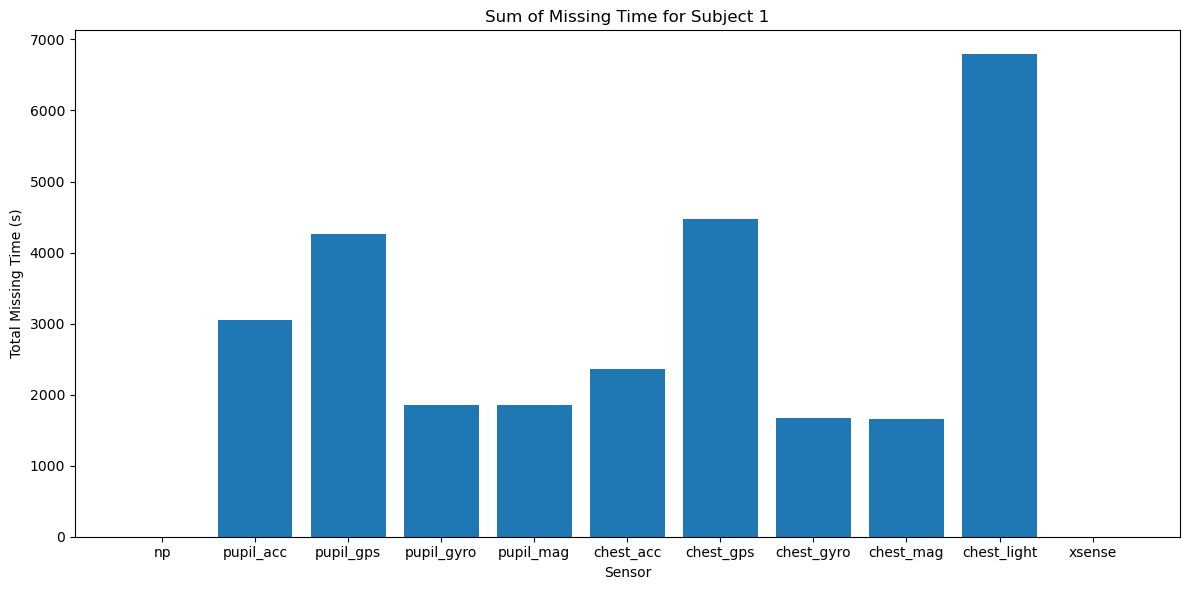

In [122]:
from collections import defaultdict
import matplotlib.pyplot as plt

data = [
    {"np": 0.0, "pupil_acc": 592.647, "pupil_gps": 625.985, "pupil_gyro": 285.571, "pupil_mag": 284.825, "chest_acc": 453.561, "chest_gps": 743.392, "chest_gyro": 226.834, "chest_mag": 223.319, "chest_light": 1034.177, "xsense": 0.0},
    {"np": 0.0, "pupil_acc": 413.343, "pupil_gps": 854.75, "pupil_gyro": 348.183, "pupil_mag": 348.939, "chest_acc": 385.421, "chest_gps": 778.087, "chest_gyro": 284.101, "chest_mag": 280.658, "chest_light": 1325.806},
    {"np": 0.0, "pupil_acc": 457.735, "pupil_gps": 641.046, "pupil_gyro": 223.691, "pupil_mag": 222.579, "chest_acc": 425.9, "chest_gps": 813.236, "chest_gyro": 250.831, "chest_mag": 249.81, "chest_light": 1090.424},
    {"np": 0.0, "pupil_acc": 409.766, "pupil_gps": 657.625, "pupil_gyro": 318.603, "pupil_mag": 318.879, "chest_acc": 270.004, "chest_gps": 709.053, "chest_gyro": 252.52, "chest_mag": 252.143, "chest_light": 1110.526, "xsense": 0.0},
    # Walk5 misses chest data
    {"np": 0.0, "pupil_acc": 681.444, "pupil_gps": 628.529, "pupil_gyro": 383.985, "pupil_mag": 382.229, "chest_acc": 377.636, "chest_gps": 636.64, "chest_gyro": 358.157, "chest_mag": 356.29, "chest_light": 1119.961, "xsense": 0.0},
    {"np": 0.0, "pupil_acc": 488.91, "pupil_gps": 855.104, "pupil_gyro": 299.492, "pupil_mag": 296.335, "chest_acc": 450.819, "chest_gps": 793.458, "chest_gyro": 291.119, "chest_mag": 287.29, "chest_light": 1108.469, "xsense": 0.0}
]

totals = defaultdict(int)
for d in data:
    for key, value in d.items():
        totals[key] += value

totals = dict(totals)
print(totals)

## Draw plot
keys = list(totals.keys())
values = list(totals.values())

plt.figure(figsize=(12, 6))
plt.bar(keys, values)
plt.xlabel('Sensor')
plt.ylabel('Total Missing Time (s)')
plt.title('Sum of Missing Time for Subject 1')
plt.tight_layout()
plt.show()

{'Doorway': 403.66700000000003, 'Pointing': 3.8819999999999997, 'Choice Point': 198.29, 'Correct Turn': 153.465, 'Talking': 86.779, 'Abnormal': 246.86399999999998, 'Lost': 59.006, 'Stare': 29.781, 'Incorrect Turn': 20.691, 'Stop': 25.0}


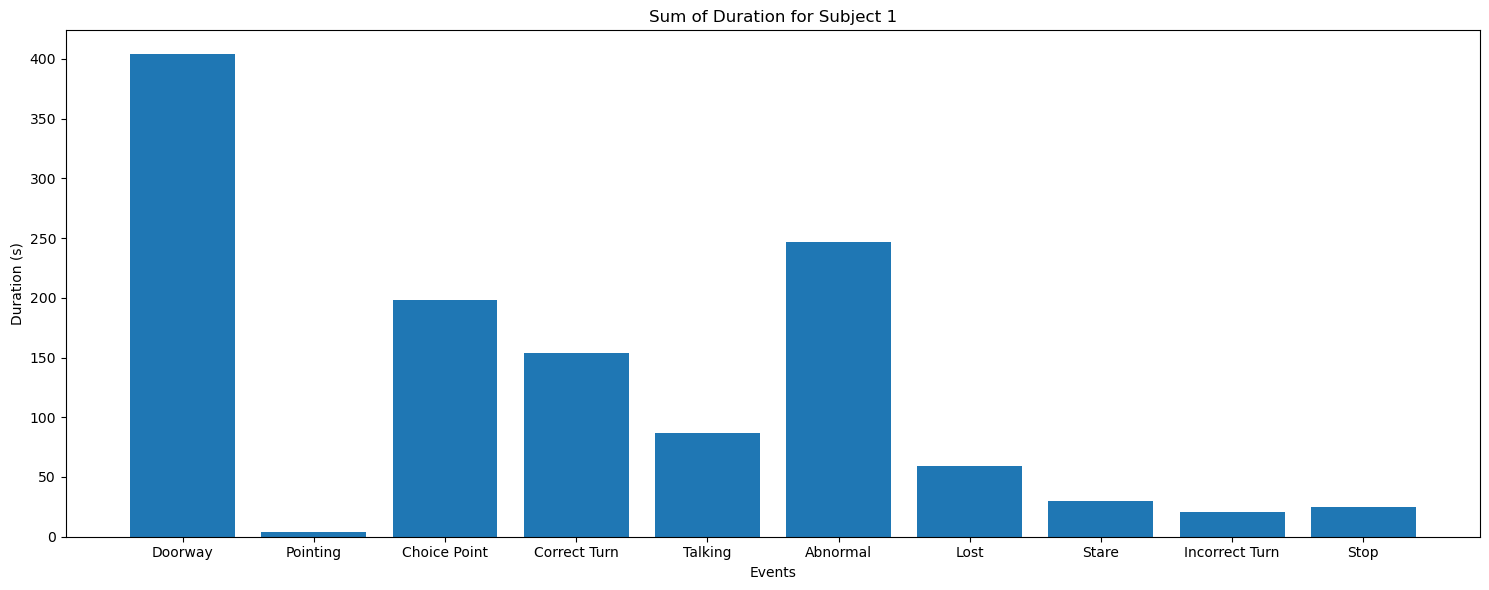

In [124]:
from collections import defaultdict
import matplotlib.pyplot as plt

data_ext = [
    {'Doorway': '0:02:26.617000',
    'New Context': '0:14:44.787000',
    'Outdoor': '0:09:04.672000',}, # Walk1

    {'Doorway': '0:02:32.537000',
    'New Context': '0:15:15.934000',
    'Outdoor': '0:09:08.663000',}, # Walk4

    {'Doorway': '0:01:44.513000',
    'New Context': '0:12:42.926000',
    'Outdoor': '0:03:58.310000',} # Walk5
]

data_propri = [
    {'Pointing': '0:00:01.789000',
    'Choice Point': '0:01:06.916000',
    'Correct Turn': '0:00:59.647000',
    'Talking': '0:00:44.380000',
    'Abnormal': '0:01:12.880000',
    'Lost': '0:00:10.687000',
    'Stare': '0:00:10.726000',
    'Incorrect Turn': '0:00:03.436000'}, # Walk1

    {'Choice Point': '0:01:37.248000',
    'Correct Turn': '0:00:59.400000',
    'Lost': '0:00:30.076000',
    'Talking': '0:00:25.214000',
    'Stop': '0:00:20.734000',
    'Abnormal': '0:01:29.588000',
    'Incorrect Turn': '0:00:12.138000',
    'Pointing': '0:00:02.093000',
    'Stare': '0:00:09.728000'}, # Walk4

    {'Lost': '0:00:18.243000',
    'Talking': '0:00:17.185000',
    'Choice Point': '0:00:34.126000',
    'Correct Turn': '0:00:34.418000',
    'Incorrect Turn': '0:00:05.117000',
    'Abnormal': '0:01:24.396000',
    'Stare': '0:00:09.327000',
    'Stop': '0:00:04.266000'} # Walk5
]

time_format = '%H:%M:%S.%f'
totals_dura_ext = defaultdict(int)
for d in data_ext:
    for key, value in d.items():
        time = datetime.datetime.strptime(value, time_format) - datetime.datetime.strptime('0:00:00.000000', time_format)
        totals_dura_ext[key] += time.total_seconds()

totals_dura_propri = defaultdict(int)
for d in data_propri:
    for key, value in d.items():
        time = datetime.datetime.strptime(value, time_format) - datetime.datetime.strptime('0:00:00.000000', time_format)
        totals_dura_propri[key] += time.total_seconds()

# totals_dura = dict(totals_dura_ext)
totals_dura = {**totals_dura_ext, **totals_dura_propri}
print(totals_dura)

## Draw plots
keys = list(totals_dura.keys())
values = list(totals_dura.values())
plt.figure(figsize=(15, 6))
plt.bar(keys, values)
plt.xlabel('Events')
plt.ylabel('Duration (s)')
plt.title('Sum of Duration for Subject 1 (All)')
plt.tight_layout()

keys = list(totals_dura_ext.keys())
values = list(totals_dura_ext.values())
plt.figure(figsize=(15, 6))
plt.bar(keys, values)
plt.xlabel('Events')
plt.ylabel('Duration (s)')
plt.title('Sum of Duration for Subject 1 (Exteroceptive)')
plt.tight_layout()

keys = list(totals_dura_propri.keys())
values = list(totals_dura_propri.values())
plt.figure(figsize=(15, 6))
plt.bar(keys, values)
plt.xlabel('Events')
plt.ylabel('Duration (s)')
plt.title('Sum of Duration for Subject 1 (Proprioceptive)')
plt.tight_layout()

plt.show()

### Extract xsense - general data subsheet

In [19]:
import pandas as pd
import os

subject = 1
walk = 3

source_folder = f"E:/BrainNavigationData/RW{subject}/Original/Walk{walk}"
save_folder = f"E:/BrainNavigationData/RW{subject}/RW{subject}-Walk{walk}-extracted/"
# df = pd.ExcelFile(os.path.join(source_folder, f'Xsens/RW_{subject}_w{walk}.xlsx'))
# df.sheet_names
df = pd.read_excel(os.path.join(source_folder, f'Xsens/RW_{subject}_w{walk}.xlsx'), sheet_name='General Information')
df.to_csv(save_folder + 'data_xs_General_Information.csv', index=False)